In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from scipy.interpolate import RectBivariateSpline
path = '../PostBornEma/'
sys.path.append("../scripts/") 
from lab import *

### 1) Non-Limber Terms Equations 4.6-4.7

#### Collecting all contributions from Eq.s 4.2-4.5 that are also non-zero in Limber

Term 1:
$2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 l^2 \int \mathrm{d}\chi \int \mathrm{d}\chi' W(\chi,\chi_{CMB}) W^h(\chi') \int \mathrm{d}\chi'' W(\chi'',\chi) C_l^{\psi\psi}(\chi'',\chi)   C_L^{\delta\phi}(\chi',\chi'')\\
= 2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 l^2 \int \mathrm{d}\chi W(\chi,\chi_{CMB}) \int_0^\chi \mathrm{d}\chi'' W(\chi'',\chi) C_l^{\psi\psi}(\chi'',\chi)   C_L^{g\phi}(\chi'') $




In [3]:
chimaxs = np.load('../G_matrices/clphigalchimaxs_VB.npy')
clgphi  = np.load('../G_matrices/clphigal_VB.npy')
#check if chimaxs are in correct order


r2d, t2d = np.meshgrid(t_,t_)
np.prod((chimaxs==r2d*t2d*chi_cmb))

1

In [4]:
clgphi_Chirag = np.load('../output/cm_clmesh/clphideltacmb_1plusz.npy')

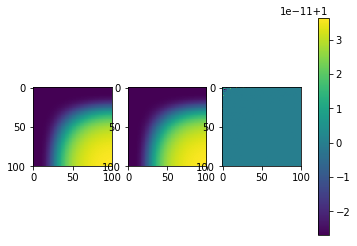

In [5]:
fig, ax = plt.subplots(ncols=3,nrows=1)
a = ax[0].imshow(clgphi_Chirag[10])
b = ax[1].imshow(clgphi[10])
c = ax[2].imshow(clgphi_Chirag[10]/clgphi[10])
fig.colorbar(c, ax=ax)


In [6]:
def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi)

kernel1 = lensing_kernel
kernel2 = lsst_kernel_cb

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
#nu axis
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

clgphi_  = np.expand_dims(clgphi,-1)


result   = np.zeros((len(ell_),len(ell_)))

chimax   = chi_cmb

n = 0

begin=time.time()
for nn in range(len(ell_)):
    if nn%10==0:
        print(nn)
    chi1fac0 = (kernel1(r2d*chimax,chimax)*D_chi(r2d*chimax)*(1.+z_chi(r2d*chimax)))
    chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

    chi2fac00 = kernel1(r2d*t2d*chimax,chimax*r2d)*D_chi(r2d*t2d*chimax)*(1.+z_chi(r2d*t2d*chimax))*clgphi_[nn]
#     chi2fac01 = (kernel2(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax)*clphiphir_over_t_[nn])
#     chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
    chi2fac0  = chi2fac00

    chifacs   = w11*w12*chi1fac0* chi2fac0

    lmax = ell_.size
    for ii  in range(ell_.size):        
        result[nn][ii] = np.sum(chifacs*I0_ltrc[ii])
        
print(time.time()-begin)

MA = chimax * result*1./np.pi**2/2.*prefac**2/4.


# to do: check if l grids are correct

0


/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:38: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
341.208341837


In [7]:
bin_num = 'all'
#first index L, second index l
np.save('../M_matrices/MB1_bin_%s'%str(bin_num),[np.meshgrid(ell_),MA])

In [8]:
MB1_Chirag = np.load('../output/cm_clmesh/cl31b_1plusz.npy')

In [9]:
MB1_Chirag.shape

(289, 289)

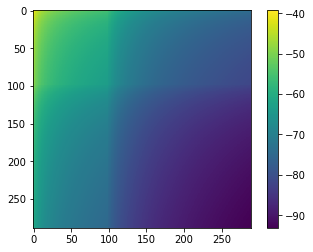

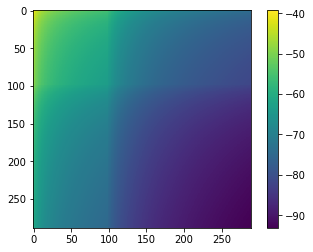

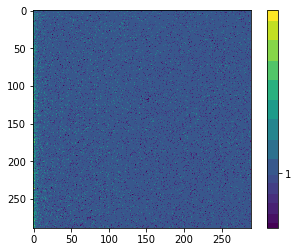

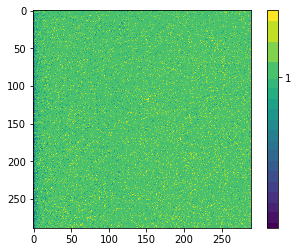

1.4065668404881894e-16

In [18]:
MB1 = RectBivariateSpline(ell_,ell_,MA)
plt.imshow(np.log(MA))
plt.colorbar()
plt.show()
plt.imshow(np.log(MB1_Chirag))
plt.colorbar()
plt.show()

plt.imshow((MB1_Chirag/MA))
plt.colorbar()
plt.show()

plt.imshow((MA/MB1_Chirag))
plt.colorbar()
plt.show()

np.mean(MA/MB1_Chirag)
np.std(MA/MB1_Chirag)

In [19]:
L = np.logspace(np.log10(min(ell_)),np.log10(max(ell_)),100)
l = np.logspace(np.log10(min(ell_)),np.log10(max(ell_)),500)

def l_integration_1(M,L,l):
    return L**2*np.trapz(l**5*M(L,l),l)/2./np.pi


In [20]:
res=[]
for LL in L:
    res+=[l_integration_1(MB1,LL,l)]
res = np.asarray(res)

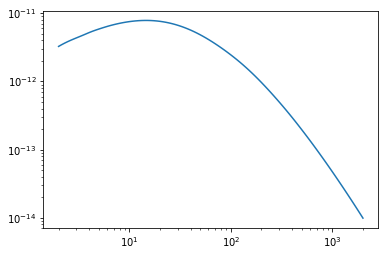

In [21]:
plt.loglog(L,res)


Term 2:
$-2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 L^2 \int \mathrm{d}\chi \int \mathrm{d}\chi' W(\chi,\chi_{CMB}) W^h(\chi') \int_0^{\chi'} \mathrm{d}\chi'' W(\chi'',\chi) C_L^{\psi\psi}(\chi'',\chi)   C_l^{\delta\phi}(\chi',\chi'')\\
= -2 \int_{\vec{l}} [\vec{L}\cdot \vec{l}]^2 L^2 \int \mathrm{d}\chi'  W^h(\chi') \int_0^{\chi'} \mathrm{d}\chi'' W(\chi'',\chi) C_L^{\psi\phi}(\chi'')   C_l^{\delta_h \phi}(\chi',\chi'') $

In [3]:
clphidelta  = np.load('../G_matrices/clphidelta_parallel_MB2_nosym.npy')

clphipsi    = np.load('../G_matrices/clpsiphi_parallel_MB2.npy')
print(clphidelta.shape)
print(clphipsi.shape)

(289, 100, 100)
(289, 100, 100)


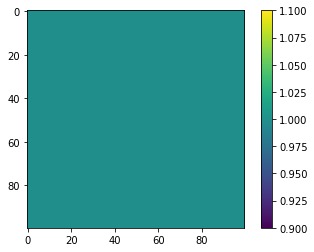

In [7]:
chimaxs = np.load('../G_matrices/clphidelta_parallel_MB2_chimaxs.npy')
chimaxs2 =  t_.reshape(-1, 1)*t_.reshape(1, -1)*chi_cmb
plt.imshow(chimaxs2/chimaxs)
plt.colorbar()



In [4]:
clphidelta_Chirag  = np.load('../output/cm_clmesh/cldeltachiphi.npy')
clphipsi_Chirag   = np.load('../output/cm_clmesh/clpsiphicmb.npy')

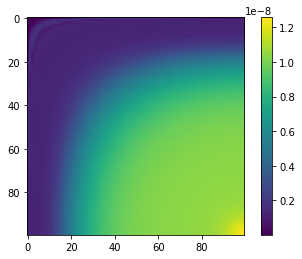

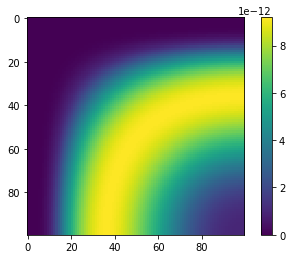

In [12]:
r2d, t2d = np.meshgrid(t_,t_)
plt.imshow(clphipsi[10])
plt.colorbar()
plt.show()
plt.imshow(clphipsi_Chirag[10]*(1+z_chi(r2d*t2d*chi_cmb)))
plt.colorbar()

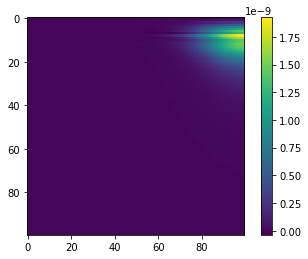

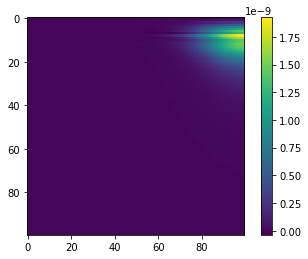

In [65]:
plt.imshow(clphidelta[10])
plt.colorbar()
plt.show()
plt.imshow(clphidelta_Chirag[10])
plt.colorbar()

In [73]:
def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi)

kernel2 = lensing_kernel
kernel1 = lsst_kernel_cb

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
#nu axis
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)



result   = np.zeros((len(ell_),len(ell_)))

chimax   = chi_cmb

n = 0

begin=time.time()
for nn in range(len(ell_)):
    if nn%10==0:
        print(nn)
    chi1fac0 = kernel1(r2d*chimax)
    chi1fac0 = chi1fac0 *(r2d*chimax)

    chi2fac00 = kernel2(r2d*t2d*chimax,chimax*r2d)*clphipsi[nn]
    chi2fac0  = chi2fac00

    chifacs   = w11*w12*chi1fac0* chi2fac0

    lmax = ell_.size
    for ii  in range(ell_.size):        
        result[nn][ii] = np.sum(chifacs*clphidelta[ii])
        
#first index is L
MB = chimax *chi_cmb*result*1./np.pi**2/2.*prefac/4.*0.5

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280


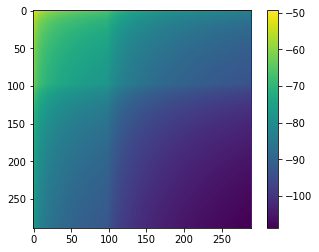

In [66]:
plt.imshow(np.log(MA))
plt.colorbar()

In [67]:
MB2 = RectBivariateSpline(ell_,ell_,MA)

In [68]:
def l_integration_2(M,L,l):
    return -L**4*np.trapz(l**3*M(L,l),l)/2./np.pi

In [69]:
res=[]
for LL in L:
    res+=[l_integration_2(MB2,LL,l)]
res = np.asarray(res)

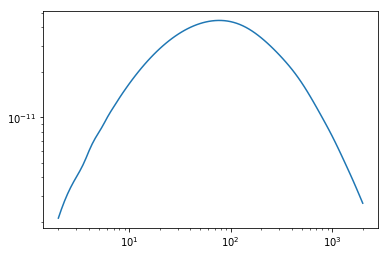

In [71]:
plt.loglog(L,-res)

Term 3:
$- 1/2 \int_{\vec{l}} l^2 L^4 \int \mathrm{d}\chi  W(\chi,\chi_{CMB})\int \mathrm{d}\chi'  W^h(\chi') C_L^{\phi\phi}(\chi',\chi_{CMB})   C_l^{\delta\psi}(\chi',\chi)$

simply use $C_L^{g\phi}$ code with augmented kernel

In [74]:
clphiphi_t = np.load('../G_matrices/clphiphi_MB3_a.npy')

clphiphi_overt = np.load('../G_matrices/clphiphi_MB3_b.npy')

In [78]:
r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
#nu axis
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)

clphiphi1  = np.expand_dims(clphiphi_t,-1)
clphiphi2  = np.expand_dims(clphiphi_overt,-1)
# chimax and kernels
chimax   = chi_cmb

kernel1  = lensing_kernel
kernel2  = lsst_kernel_cb

n = 2

result   = np.zeros((len(ell_),len(ell_)))

begin=time.time()
for nn in range(len(ell_)):
    if nn%10==0:
        print(nn)
    chi1fac0 = (kernel1(r2d*chimax,chimax)*D_chi(r2d*chimax))
    chi1fac0 = chi1fac0 *(r2d*chimax)**(1-(n+nu_n_.reshape(1, 1, -1)))

    chi2fac00 = (kernel2(t2d*r2d*chimax)*D_chi(r2d*t2d*chimax)*clphiphi1[nn])
    chi2fac01 = (kernel2(1./t2d*r2d*chimax)*D_chi(r2d/t2d*chimax)*clphiphi2[nn])
    chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
    chi2fac0  = chi2fac00 + chi2fac01

    chifacs = w11*w12*chi1fac0* chi2fac0

    for ii  in range(ell_.size):        
        result[nn][ii] = np.sum(chifacs*I2_ltrc[ii])
    
# first index is L
result*=chimax * result*1./np.pi**2/2.*prefac/4.*2


0


/global/common/cori/software/python/2.7-anaconda-5.2/lib/python2.7/site-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
240
250
260
270
280


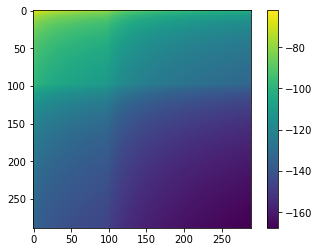

In [79]:
plt.imshow(np.log(result))
plt.colorbar()

In [80]:
MB3 = RectBivariateSpline(ell_,ell_,result)

In [81]:
def l_integration_3(M,L,l):
    return 2*L**4*np.trapz(l**3*M(L,l),l)/2./np.pi

In [82]:
res=[]
for LL in L:
    res+=[l_integration_2(MB2,LL,l)]
res = np.asarray(res)